# Long short term memory network

This practice illustrates the use of LSTM for modelling time series. You will learn:
- get data of stocks using package of yfinance.
- organise time series data in the format of 3D data matrix required by keras LSTM
- build a lstm model for stock price prediction of the next day.

You will need to install yfiance at your first time of use: 

pip install yfinance

See https://algotrading101.com/learn/yfinance-guide/ for a guide of using yfinance

Note this is a hugely simplified stock price prediction, it is only used for lstm illustration purpose. 

In [1]:
pip install yfinance

     |████████████████████████████████| 63 kB 353 kB/s 
     |████████████████████████████████| 6.4 MB 7.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
#import datetime
#import time
import requests
import io

## Download stock data
For company names and their stock symbol, see https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv

In [3]:
!wget https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv

# Set the date range

#start = datetime.datetime(2020,2,1)
#end = datetime.datetime(2020,10,11)


--2022-03-12 00:39:56--  https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.21.40.221, 172.67.157.38, 2606:4700:3030::ac43:9d26, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.21.40.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259096 (253K) [text/plain]
Saving to: ‘nasdaq-listed_csv.csv’

nasdaq-listed_csv.c 100%[===================>] 253.02K  --.-KB/s    in 0.05s   

2022-03-12 00:39:57 (5.20 MB/s) - ‘nasdaq-listed_csv.csv’ saved [259096/259096]



In [4]:
# download Tesla stock data -> TSLA

#stock = yf.download('TSLA',start=start, end=end, progress=False)
stock = yf.download(['TSLA'],start="2015-01-01", end="2021-03-19") #, progress=False)


[*********************100%***********************]  1 of 1 completed


In [5]:
pd.set_option('display.max_columns', None, 'display.expand_frame_repr', False)
#print(stock.info())
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,44.574001,44.650002,42.652000,43.862000,43.862000,23822000
2015-01-05,42.910000,43.299999,41.431999,42.018002,42.018002,26842500
2015-01-06,42.012001,42.840000,40.841999,42.256001,42.256001,31309500
2015-01-07,42.669998,42.956001,41.956001,42.189999,42.189999,14842000
2015-01-08,42.562000,42.759998,42.001999,42.124001,42.124001,17212500


In [6]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1.563000e+03
mean,115.829383,118.438952,112.976285,115.919608,115.919608,3.995792e+07
std,165.092330,169.116198,160.353847,165.221387,165.221387,2.929621e+07
min,28.464001,30.993999,28.209999,28.733999,28.733999,3.540000e+06
25%,45.802999,46.389999,45.000999,45.796000,45.796000,2.135325e+07
50%,58.216000,59.492001,57.035999,58.242001,58.242001,3.091050e+07
75%,70.756001,71.737000,69.680000,70.563999,70.563999,4.761400e+07
max,891.380005,900.400024,871.599976,883.090027,883.090027,3.046940e+08


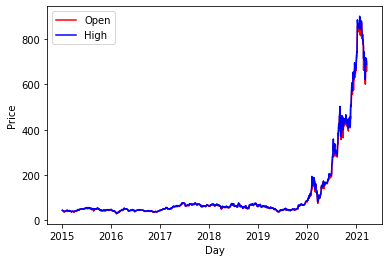

In [7]:
# plot Open and High price
plt.plot(stock['Open'], color = 'red', label = 'Open')
plt.plot(stock['High'], color = 'blue', label = 'High')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

## Split data for training and test

In [11]:
# use open and high only in this example

values = stock.iloc[:, 1:3].values
values.shape

(1563, 2)

The split below uses ratio between training and test that we used before. However, for stock price modelling, we'd better speficify time periods for training, validation and test. For example, stock data from 2010-03-15 to 2018-12-31 for training, 2019-01-01 to 2020-10-31 for validation, and 2020-11-01 to 2021-02-28 for test.

In [12]:
# split into trainind and test datasets
ratio = round(0.8*values.shape[0])
train_values = values[:ratio, :]
test_values = values[ratio:, :]
print('trainind data size: ', train_values.shape, '\n    test data size: ', test_values.shape)

trainind data size:  (1250, 2) 
    test data size:  (313, 2)


## Convert the data for supervised learning

In [13]:
from pandas import concat

# convert series to supervised learning by Jason Brownlee 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [14]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)

lags = 2
features = train_scaled.shape[1]
print(lags, features)
 
# frame as supervised learning
train_reframed = series_to_supervised(train_scaled, lags, 1)
print(train_reframed)
# drop columns we don't want to predict
train_reframed.drop(train_reframed.columns[[-1]], axis=1, inplace=True)

test_scaled = scaler.transform(test_values)
test_reframed = series_to_supervised(test_scaled, lags, 1)
test_reframed.drop(test_reframed.columns[[-1]], axis=1, inplace=True)

print(train_reframed.head())
print(test_reframed.head())

2 2
      var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)   var2(t)
2      0.284204   0.301465   0.256108   0.275999  0.246535  0.263683
3      0.256108   0.275999   0.246535   0.263683  0.248949  0.286937
4      0.246535   0.263683   0.248949   0.286937  0.244870  0.287897
5      0.248949   0.286937   0.244870   0.287897  0.228970  0.266814
6      0.244870   0.287897   0.228970   0.266814  0.206035  0.242976
...         ...        ...        ...        ...       ...       ...
1245   0.814818   0.827704   0.841707   0.876884  0.864807  0.885818
1246   0.841707   0.876884   0.864807   0.885818  0.875088  0.891705
1247   0.864807   0.885818   0.875088   0.891705  0.951675  0.924519
1248   0.875088   0.891705   0.951675   0.924519  0.959542  0.980462
1249   0.951675   0.924519   0.959542   0.980462  1.000000  1.000000

[1248 rows x 6 columns]
   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
2   0.284204   0.301465   0.256108   0.275999  0.246535
3   0.256108   0.275999   0.246

In [15]:
# split into input and outputs
values_train = train_reframed.values
values_test = test_reframed.values

train_X, train_y = values_train[:, :-1], values_train[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]
print(train_X.shape, test_X.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 2, features))
test_X = test_X.reshape((test_X.shape[0], 2, features))
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1248, 4) (311, 4)
(1248, 2, 2) (1248,) (311, 2, 2) (311,)


## Define and train LSTM

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
18/18 - 6s - loss: 0.3935 - val_loss: 5.9349 - 6s/epoch - 339ms/step
Epoch 2/50
18/18 - 0s - loss: 0.1619 - val_loss: 4.5253 - 112ms/epoch - 6ms/step
Epoch 3/50
18/18 - 0s - loss: 0.0784 - val_loss: 3.8780 - 108ms/epoch - 6ms/step
Epoch 4/50
18/18 - 0s - loss: 0.0825 - val_loss: 3.6868 - 111ms/epoch - 6ms/step
Epoch 5/50
18/18 - 0s - loss: 0.0675 - val_loss: 3.3899 - 104ms/epoch - 6ms/step
Epoch 6/50
18/18 - 0s - loss: 0.0538 - val_loss: 3.1406 - 107ms/epoch - 6ms/step
Epoch 7/50
18/18 - 0s - loss: 0.0430 - val_loss: 2.9643 - 93ms/epoch - 5ms/step
Epoch 8/50
18/18 - 0s - loss: 0.0343 - val_loss: 2.8747 - 110ms/epoch - 6ms/step
Epoch 9/50
18/18 - 0s - loss: 0.0290 - val_loss: 2.8296 - 98ms/epoch - 5ms/step
Epoch 10/50
18/18 - 0s - loss: 0.0284 - val_loss: 2.8288 - 106ms/epoch - 6ms/step
Epoch 11/50
18/18 - 0s - loss: 0.0288 - val_loss: 2.8544 - 99ms/epoch - 6ms/step
Epoch 12/50
18/18 - 0s - loss: 0.0281 - val_loss: 2.8709 - 103ms/epoch - 6ms/step
Epoch 13/50
18/18 - 0s - loss

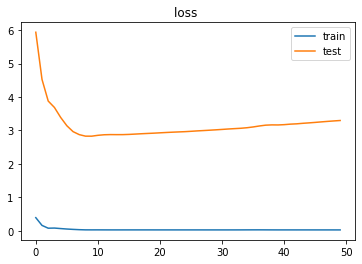

In [17]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [18]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = concatenate((yhat, yhat), axis=1)
#inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 242.286


## Show the actual and predicted price

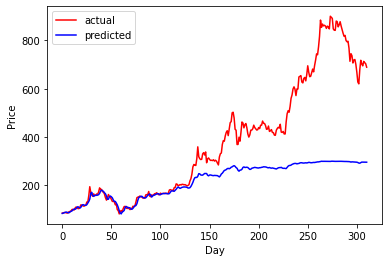

In [19]:
plt.plot(inv_y, color = 'red', label = 'actual')
plt.plot(inv_yhat, color = 'blue', label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

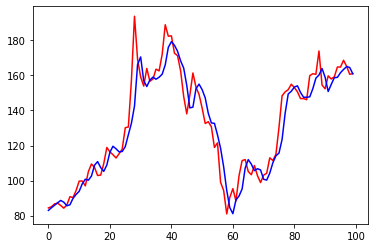

In [20]:

plt.plot(inv_y[:100], color = 'red', label = 'actual')
plt.plot(inv_yhat[:100], color = 'blue', label = 'predicted')

## Exercise
Download a different stock data and use the four prices of Open-High-Low-Close of 5 days (current day and four previous days) to predict Close price of the next day.